<a href="https://colab.research.google.com/github/gamedaygeorge/datacube-applications-library/blob/odc-colab/DCAL_Cloud_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="top"></a>
# Cloud Statistics <img align="right" style="padding:10px" src="https://github.com/gamedaygeorge/datacube-applications-library/blob/master/images/odc_logo.png?raw=1">

This notebook explores Landsat-7 and Landsat-8 Data Cubes and reports cloud statistics for selected regions within a cube. This is valuable information for performing analysis. For example, if there are extensive clouds for a season it may significantly impact the mosaic product or index values. Another example is that a user may want to find a single date when there are few clouds to assess land features.

What does this Notebook do?

* [Setup the Environment](#environment_setup)
* [Explore the Data](#explore_data)
* [Calculate Cloud Coverage Percentage](#calc_cloud_coverage)
* [Create and RGB Image of a Time Slice](#rgb_image)
* [Contributors, Heritage and References](#contributors_heritage)

This notebook uses external functions including both a standard set of DCAL utilities (see folder [DCAL_utils](../DCAL_utils)) and a code behind file containing some specalised functions that make this page work (see file [DCAL_Cloud_Statistics.py](DCAL_Cloud_Statistics.py)).

<i><p style="color:red"><b>Red Text:</b> Indicates code blocks where user inputs can be provided.</p></i>

<a id="environment_setup"></a>
## Environment Setup [&#9652;](#top)
* **Surpress Python Warnings:** These warnings include notes about deprecitation of Python modules, etc.
* **Import Standard Python Modules:** Import external and standard Python modules including `datacube` which is part of the ODC framework, as well as `xarray` which is a useful external module.
* **Import DCAL Utilities:** Import a set of utilities developed by the DCAL team to help automate some of the more routine tasks in the notebooks. These utilities are located in `/DCAL_utils`.
* **Initialize Data Cube and Data Cube API**

[Back to Top](#top)

In [ ]:
# Clone GitHub repo for code behinds
!git clone -b odc-colab https://github.com/gamedaygeorge/datacube-applications-library.git

import os
os.chdir('/content/datacube-applications-library/DCAL_notebooks')
os.getcwd()

In [ ]:
# Setup ODC on colab
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init()

In [ ]:
# Load ODC index
from odc_colab import populate_db
populate_db()

In [ ]:
# Supress Python Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import Required Standard Python Modules
import datacube
import sys
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
# Import notebook code behind (as cb) contaning function definitions specific to this notebook
import DCAL_Cloud_Statistics as cb

# Import DCAL utilities containing function definitions used generally across DCAL
# Add DCAL_utils to the sys.path
sys.path.append('../DCAL_utils')

# Import Data Cube API
import data_access_api as dc_api

# Import Display Map functions
from dc_display_map import display_map

In [ ]:
# Load Data Cube Configuration
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

<a id="explore_data"></a>
## Explore Data [&#9652;](#top)
* **Select Product:** Specify the product you desire to use. Note you can see the complete list of products in this Cube in the introductory notebook (<a href="../Open%20Data%20Cube%20Application%20Library%20Notebooks.ipynb#products" target="_blank">click here</a>).
* **View Dataset Spatial and Temporal Extents:** Queries the Cube and displays the min/max latitude and longitude, and the start and end date and time.
* **Select Spatial and Temporal Extents:** Select the area of interest (AOI) and time range based on extents available.
* **Display the Area of Interest:** Renders a map of the AOI.

<p style="color:red";><b>Select Products:</b> Select Data Cube products based on what is available. (<a href="../OpenDataCube_Application_Library_Notebooks.ipynb#products" target="_blank" style="color:red">Click here to inspect available products</a>.)</p>

[Back to Top](#top)

In [ ]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_ledaps_ghana"
# platform = "LANDSAT_7"

product = "ls8_lasrc_ghana"
platform = "LANDSAT_8"

# product = "ls8_lasrc_kenya"
# platform = "LANDSAT_8"

In [ ]:
# Print spatial and temporal extents of the Data Cube
extents = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))

print('Data Cube latitude min ... max: ' + str(latitude_extents[0]) + ' ... ' + str(latitude_extents[1]))
print('Data Cube longitude min ... max: ' + str(longitude_extents[0]) + ' ... ' + str(longitude_extents[1]))

start_date_time = pd.to_datetime(str(time_extents[0]))
end_date_time = pd.to_datetime(str(time_extents[1]))

print('Start datetime: ' + start_date_time.strftime('%Y-%m-%d %H:%M:%S'))
print('End datetime: ' + end_date_time.strftime('%Y-%m-%d %H:%M:%S'))

Data Cube latitude min ... max: 3.7730589405966173 ... 11.318637832619382
Data Cube longitude min ... max: -3.772789446011382 ... 1.8863273493593828
Start datetime: 2013-04-13 10:10:55
End datetime: 2020-01-27 10:09:38


<p style="color:red";><b>Select Spatial and Temporal Extents:</b> Select the area of interest (AOI) and time range based on extents available.</p>

In [ ]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Kumasi, Ghana
# latitude = (6.529, 6.8734) 
# longitude = (-1.7954, -1.4211)

# Mau Forest - Western Kenya
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Mining Region near Obuasi, Ghana
latitude = (6.0985, 6.2675)
longitude = (-2.050, -1.8629)

# Time Period
time_extents = ('2019-01-01', '2019-12-31')

In [ ]:
# Render a map of the Area of Interest.
display_map(latitude,longitude)

<a id="calc_cloud_coverage"></a>
## Calculate Cloud Coverage Percentage [&#9652;](#top)

* **Define Function:** to build a cloud coverage table for Landsat.
* **Build Cloud Coverage Table:** Call function to build Landsat dataset and cloud coverage table.
* **Create Table:** Create and print table of cloud coverage percentage for each date.
* **Plot:** Create a plot of cloud coverage percentage for each date.

[Back to Top](#top)

In [ ]:
# Build landsat dataset and cloud coverage table (calling function in code behind)
# GD NOTES: What is the purpose of extra_band?
extra_band = 'green'
landsat_dataset, coverage_table = cb.build_cloud_coverage_table_landsat(product = product,
                                                                  platform = platform,
                                                                  latitude = latitude,
                                                                  longitude = longitude,
                                                                  time = time_extents,
                                                                  extra_band=extra_band)

In [ ]:
# Create and print a table of cloud coverage percentage for each date
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2019-01-06 10:21:44,99.372222,433720
1,2019-01-22 10:21:41,13.543280,59111
2,2019-02-07 10:21:38,42.152316,183978
3,2019-03-11 10:21:29,93.502726,408102
4,2019-03-27 10:21:26,73.721761,321766
5,2019-04-12 10:21:21,22.161252,96725
6,2019-04-28 10:21:16,36.417541,158948
7,2019-05-14 10:21:26,70.393392,307239
8,2019-05-30 10:21:35,0.074234,324
9,2019-06-15 10:21:42,0.679100,2964


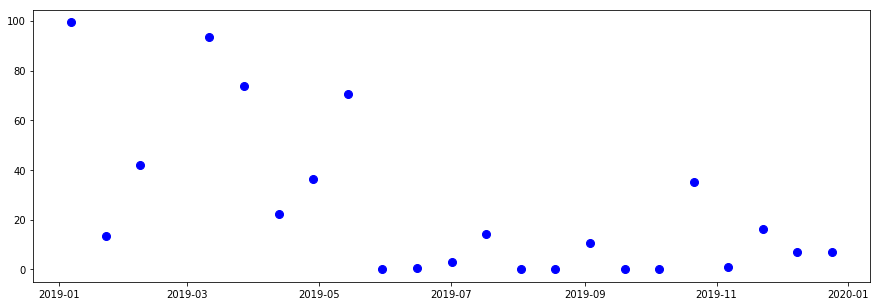

In [ ]:
# Create a plot of cloud coverage percentage for each date.
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.show()

<a id="rgb_image"></a>
## Produce an RGB Image for a Selected Time Slice [&#9652;](#top)
* **Load Data:** Load the data to create an RGB image.
* **Print Dataset Summary:** Review the contents of the dataset.
* **Select Time Slice:** Select one of the time slices and create an RGB image.

[Back to top](#top)

In [ ]:
# Load the data to create an RGB image
# GD NOTE: Why re-load landsat_dataset here? Can we just load landsat_dataset first time around with all measurements?
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2'],
                          group_by='solar_day') 

In [ ]:
# Review the contents of the dataset
# Latitude and Longitude dimensions are in pixels
# Time dimension is the number of acquisitions in the time period
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 628, longitude: 695, time: 22)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-06T10:21:44 ... 2019-12-24T10:22:08
  * latitude   (latitude) float64 6.268 6.267 6.267 6.267 ... 6.099 6.099 6.099
  * longitude  (longitude) float64 -2.05 -2.05 -2.049 ... -1.863 -1.863 -1.863
Data variables:
    red        (time, latitude, longitude) int16 684 594 682 ... 907 647 1205
    green      (time, latitude, longitude) int16 713 671 701 ... 998 812 1336
    blue       (time, latitude, longitude) int16 364 369 391 ... 575 466 1251
    nir        (time, latitude, longitude) int16 2641 2778 2526 ... 3545 3380
    swir1      (time, latitude, longitude) int16 2029 1855 1988 ... 1995 2163
    swir2      (time, latitude, longitude) int16 1255 997 1154 ... 1114 1373
Attributes:
    crs:      EPSG:4326

<p style="color:red";><b>Select Time Slice:</b> Update `slice` to an integer between 0 and landsat_dataset.dimensions.time minus 1.</p>

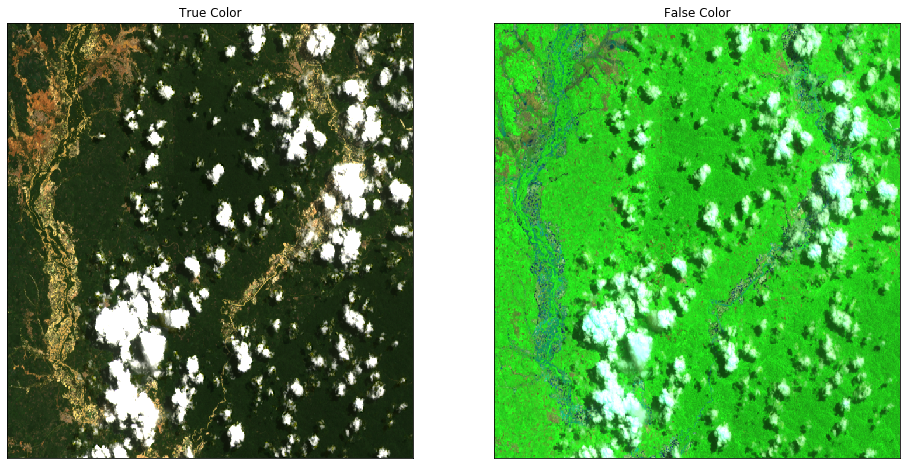

In [ ]:
# Select one of the time slices and create an RGB image. 
# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE for an RGB image

# RGB image options
# True-Color RGB = Red, Green, Blue
# False Color RGB (Landsat Mosaic) = SWIR2, NIR, Green

slice = 7 # select the time slice number here

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
true_rgb = landsat_dataset.isel(time=slice)[['red', 'green', 'blue']].to_array()
false_rgb = landsat_dataset.isel(time=slice)[['swir2', 'nir', 'green']].to_array()
true_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=3000)
false_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=5000)
ax[0].set_title('True Color'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('False Color'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

<a id="contributors_heritage"></a>
## Contributors, Heritage and References [&#9652;](#top)
The notebooks liked here have been created by Brian Killough (NASA, CEOS Systems Engineering Office) in collaboration with a number of Open Data Cube (ODC) users from the Africian Regional Data Cube, Digital Earth Australia, and other ODC users globally.

GitHub repositories referenced/forked:

- https://github.com/ceos-seo/data_cube_utilities <i>A set of utilities maintained by the CEOS SEO team in support of the Notebooks being developed.</i>
- https://github.com/ceos-seo/data_cube_notebooks <i>A set of Notebooks maintained by the CEOS SEO team.</i>
- https://github.com/GeoscienceAustralia/dea-notebooks <i>Forked this repo to include / adapt the [Beginers_guide](https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Beginners_guide) Notebooks. Basis for adaptation was [George Dyke's fork](https://github.com/gamedaygeorge/dea-notebooks).</i>

<i><b>NOTE:</b> Digital Earth Africa has adapted this notebook to run on their platform. The code is <a href="https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/DCAL/DCAL_notebooks/DCAL_Cloud_Statistics.ipynb" target="_blank">available here</a>. Their implementation cleans up some of the rougher edges that remain in this notebook.</i>

Last updated May 2020.

[Back to top](#top)